# <span style="color:#0b486b">  FIT3181: Deep Learning (2021)</span>
***
*CE/Lecturer:*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Head TA:*  **Mr Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
*Tutor:* **Dr Van Nguyen**  \[van.nguyen1@monash.edu \] | **Mr James Tong** \[james.tong1@monash.edu\] | **Dr Mahmoud Mohammad** \[mahmoud.hossam@monash.edu\]
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***


# <span style="color:#0b486b">Tutorial 5a: CNN Fundamentals</span> <span style="color:red;  font-size: 18px">***** (highly important)</span> #

**The purpose of this tutorial is to demonstrate two fundamental layers in CNN, namely convolutional and max-pooling layers. The following topics will be covered:**
1. How to declare a `convolutional layer` with TensorFlow and how it works
2. How to declare a `max-pooling layer` with TensorFlow and how it works

*Acknowledgement: this tutorial was developed based non Chapter 14 materials from the book `Hands-on Machine Learning with Scikit-learn and Tensorflow (TF 2.x edition)`.*

***

## <span style="color:#0b486b">I. Preparation</span> ##

### <span style="color:#0b486b">I.1.  Setup </span> ###
We make sure the code is compatible with both Python 2 and 3. Also, we import some basic modules and do some settings for `matplotlib`.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
# Plot images
def plot_image(image, scale=False, axis=False):
    if scale:
        plt.rcParams["figure.figsize"] = (image.shape[0]/50.0, image.shape[1]/50.0)
    if not axis:
        plt.axis("off")
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.show()

### <span style="color:#0b486b">I.2. Load two sample images using sklearn</span> ###
We now load two images using `sklearn`. These two images will be used in the sequel to demonstrate the effects of `convolutional` and `max pooling` layers.

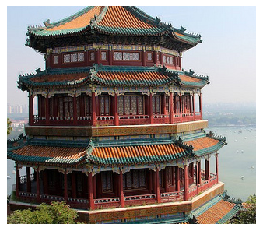

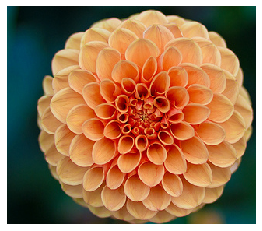

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")[80:360, 70:390]
flower = load_sample_image("flower.jpg")[80:360, 130:450]
plot_image(china)
plot_image(flower)

## <span style="color:#0b486b">II. Convolution Layer </span> ###

### <span style="color:#0b486b">II.1. Declare a convolutional layer with TF</span> ###
We use the class `tf.nn.conv2d` with the following syntax `tf.nn.conv2d(input, filter, strides, padding, name)`.
- `input` is a 4-D tensor of shape $[batch, in\_height, in\_width, in\_channels]$.
- `filter` is a tensor of shape $[filter\_height, filter\_width, in\_channels, out\_channels]$.
- `strides` is a four-element 1D array, where the two central elements are the vertical and horizontal strides ($s_h$ and $s_w$). The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer’s feature maps or channels).
- `padding` must be either `SAME` or `VALID`.
 - If set to `VALID`, the convolutional layer does not use zero-padding, and may ignore some rows and columns at the bottom and right of the input image, depending on the stride.
 - If set to `SAME`, the convolutional layer uses zero-padding if necessary. In this case, the number of output neurons is equal to the number of input neurons divided by the stride, rounded up (in this example, ceil (13 / 5) = 3). Then zeros are added as evenly as possible around the inputs.

<img src="./images/Conv2D_HandOns.png" width="500"/>

### <span style="color:#0b486b">II.2. VALID and SAME padding</span> ###

We start with examining the `VALID` and `SAME` padding for a 1-D tensor. 

If padding is set to `SAME`, we pad $0$(s) to the left and right of the 1-D tensor if necessary to ensure the starting point of the last window resides in the original tensor and the last window in the padding tensor, whereas the window after the last window is outside the original tensor.
- The output size is $output\_size=\lfloor\frac{input\_size-1}{stride}\rfloor+1$

If padding is set to `VALID`, we do not pad any $0$ and some rightmost values might be ignored, depending on the stride.
- The output size is $output\_size=\lfloor\frac{input\_size-window\_size}{stride}\rfloor+1$


<img src="./images/padding_same_valid.png" width=500 align="center"/>

In the above figure, the input size is $13$, the stride is $3$, and the window size is $5$. Therefore, we obtain
- If padding=`SAME`, then $output\_size=\lfloor\frac{13-1}{3}\rfloor+1=5$ and we need to pad $4*3 + 5-13=4$ zeros of which the two zeros are padded to the left and the two zeros are padded to the right.
- If padding=`VALID`, then $output\_size=\lfloor\frac{13-5}{3}\rfloor+1=3$ and we do not pad any zero.

For a 2-D tensor, the principle is the same, but we need to consider two dimensions: the `height` and `width`.


### <span style="color:#0b486b">II.3. An example of a convolutional layer</span> ###

Load images and create a mini-batch of two images

In [5]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg")[80:360, 70:390]
flower = load_sample_image("flower.jpg")[80:360, 130:450]
batch = np.array([china, flower], dtype=np.float32)
print(batch.shape)

(2, 280, 320, 3)


In [6]:
batch_size, height, width, channels = batch.shape

Create `filters` with $fiter\_height=7, filter\_width=7, in\_channels=3, out\_channels=2$. 
Our filters have two separate filters, each is a 3-D tensor of $7\times7\times3$.

With the first filter, we set all elements on the plane: $width=3$ to $1$. That is why it is a vertical plane.

With the first filter, we set all elements on the plane: $height=3$ to $1$. That is why it is a horizontal plane.

We finally declare a convolutional layer to apply this filter on a mini-batch of $2$ images.

In [7]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line, why?
filters[3, :, :, 1] = 1  # horizontal line, why?

We now plot the `filters`.

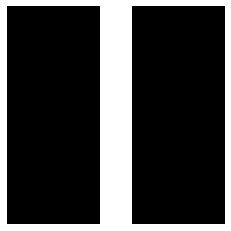

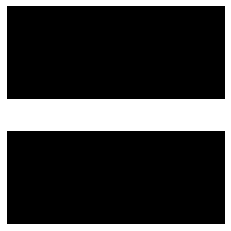

In [8]:
plot_image(filters[:, :, 0, 0])
plot_image(filters[:, :, 0, 1])

Import `TensorFlow 2.x`.

In [9]:
import tensorflow as tf

Use `tf.nn.conv2d`

Output shape:(2, 140, 160, 2)


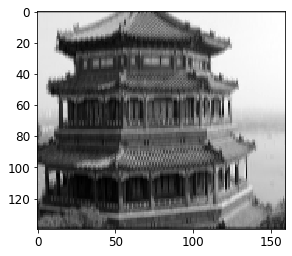

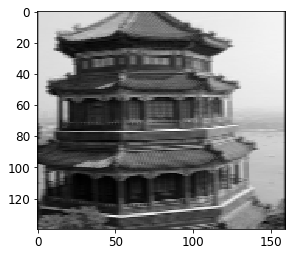

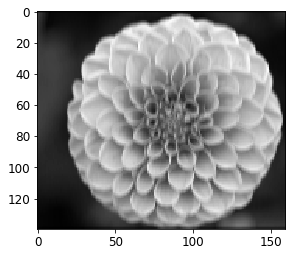

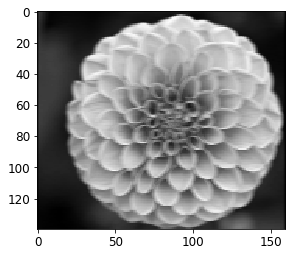

In [10]:
output = tf.nn.conv2d(batch, filters, strides=[1,2,2,1], padding="SAME")
print("Output shape:" + str(output.shape))

plot_image(output[0, :, :, 0], axis=True) # plot 1st image's 1nd feature map, channel 0
plot_image(output[0, :, :, 1], axis=True) # plot 1st image's 2nd feature map, channel 1
plot_image(output[1, :, :, 0], axis=True) # plot 2nd image's 1nd feature map, channel 0
plot_image(output[1, :, :, 1], axis=True) # plot 2nd image's 2nd feature map, channel 1

 **<span style="color:red">Exercise 1</span>:** Explain why the output shape is $(2, 140, 160, 2)$. Change the parameter padding to `VALID` and record new output size. Explain the new result.

For the case we set padding to `SAME`.

In [11]:
import math
out_height = math.floor((280-1)/2) + 1
out_width = math.floor((320-1)/2) + 1
out_channels = filters.shape[-1]    # the number of filters used
batch_size = batch.shape[0]
print('Output tensor: [{},{},{},{}]'.format(batch_size, out_height, out_width, out_channels))

Output tensor: [2,140,160,2]


For the case we set padding to `VALID`

In [12]:
output = tf.nn.conv2d(batch, filters, strides=[1,2,2,1], padding="VALID")
print('Output shape:' + str(output.shape))

Output shape:(2, 137, 157, 2)


In [13]:
out_height = math.floor((280-7)/2) + 1
out_width = math.floor((320-7)/2) + 1
out_channels = filters.shape[-1]    # the number of filters used
batch_size = batch.shape[0]
print('Output tensor: [{},{},{},{}]'.format(batch_size, out_height, out_width, out_channels))

Output tensor: [2,137,157,2]


## <span style="color:#0b486b">III. Pooling Layer </span>

### <span style="color:#0b486b">III.1. Declare a pooling layer with TF</span> ###
We use the class `tf.nn.max_pool` with the following syntax: `tf.nn.max_pool(value, ksize, strides, padding, name=None)`
- `value` is a 4-D Tensor tensor of shape $[batch, in\_height, in\_width, in\_channels]$.
- `ksize` is a 1-D int Tensor of 4 elements which is the size of the window for each dimension of the input tensor. The first and last dimensions in `ksize` must be $1$.
- `strides` is a 1-D int Tensor of 4 elements which is the stride of the sliding window for each dimension of the input tensor. The first and last dimensions in `strides` must be $1$.
- `padding` must be either `VALID` or `SAME`.

### <span style="color:#0b486b">III.2. An example of a pooling layer</span> ###

#### <span style="color:#0b486b"> Example of `Max Pooling` </span>

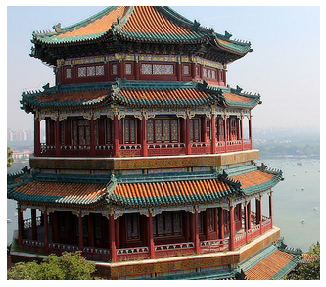

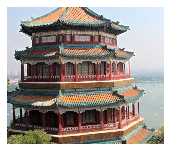

In [14]:
output = tf.nn.max_pool(input = batch, ksize=(2,2), strides=(2,2), padding="SAME")
output = output.numpy()  # convert Eager-Execution Tensor object to numpy array
plot_image(batch[0].astype(np.int32), scale=True) # plot the 1st original image
plot_image(output[0].astype(np.int32), scale=True) # plot the output for the 1st image

#### <span style="color:#0b486b"> Example of `Average Pooling` </span>

(280, 320, 3)
(140, 160, 3)


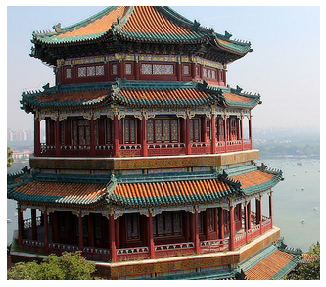

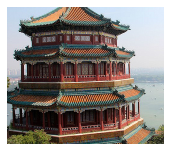

In [15]:
output = tf.nn.avg_pool(input = batch, ksize=(2,2), strides=(2,2), padding="SAME")
output = output.numpy()  # convert Eager-Execution Tensor object to numpy array
print(batch[0].shape)
print(output[0].shape)
plt.rcParams["figure.figsize"] = (batch[0].shape[0], batch[0].shape[1])
plot_image(batch[0].astype(np.int32), scale=True) # plot the 1st original image
plot_image(output[0].astype(np.int32), scale=True) # plot the output for the 1st image

## <span style="color:#0b486b">IV. Additional Reading: Effects of Convolution Operation</span>

This section aims to demonstrate the effects of convolution operation in processing images. In particular, by creating appropriate filters (kernels), we can do blurring, sharpening, embossing, or detecting edges of images. We first create some specific filters for those purposes.

### <span style="color:#0b486b">IV.1. Creating the effect filters (kernels) </span>

- Filter (kernel) for blurring images

In [16]:
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))

- Fiter (kernel) for sharpening images

In [17]:
# construct a sharpening filter
sharpen = np.array(([0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]), dtype="int")

In [18]:
sharpen_3D = np.stack([sharpen]*3, axis = 2)

In [19]:
sharpen_3D.shape

(3, 3, 3)

- Laplacian kernel for detecting edge-like

In [20]:
# construct the Laplacian kernel used to detect edge-like
# regions of an image
laplacian = np.array(([0, 1, 0], 
                      [1, -4, 1], 
                      [0, 1, 0]), dtype="int")

In [21]:
laplacian_3D = np.stack([laplacian]*3, axis=2)

- Sobel kernel for detecting edge-like regions along both the x and y axis, respectively

In [22]:
# construct the Sobel x-axis kernel
sobelX = np.array(([-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]), dtype="int")

In [23]:
sobelX_3D = np.stack([sobelX]*3, axis=2)

In [24]:
sobelY = np.array(([-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]), dtype="int")

In [25]:
sobelY_3D = np.stack([sobelY]*3, axis=2)

- Emboss kernel to emboss images

In [26]:
# construct an emboss kernel
emboss = np.array(([-2, -1, 0],
                   [-1, 1, 1],
                   [0, 1, 2]), dtype="int")

In [27]:
emboss_3D = np.stack([emboss]*3, axis=2)

- Stacking the $3 \times 3$ effect filters

In [28]:
effect_filters = np.stack([sharpen_3D, laplacian_3D, sobelX_3D, sobelY_3D, emboss_3D], axis=3)

In [29]:
effect_filters.shape

(3, 3, 3, 5)

Load the image

In [30]:
china = load_sample_image("china.jpg")[80:360, 70:390]
china = np.array([china], dtype= np.float32)
china.shape

(1, 280, 320, 3)

### <span style="color:#0b486b"> IV.2. Applying the small blurring kernels to the china image </span>

The output image is blurred a little bit.

In [41]:
print(smallBlur.shape)
filters = np.stack([smallBlur]*3, axis=2)
print(filters.shape)
filters = np.expand_dims(filters,3)
print(filters.shape)
filters

(7, 7)
(7, 7, 3)


array([[[[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]]],


       [[[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]],

        [[0.02040816],
         [0.02040816],
         [0.02040816]]],


  

(1, 280, 320, 3)
(7, 7, 3, 1)
(1, 280, 320, 1)


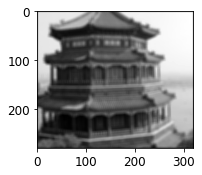

In [43]:
print(china.shape)
print(filters.shape)
output = tf.nn.conv2d(china, filters, strides=[1,1,1,1], padding="SAME")
output = output.numpy()
print(output.shape)
plt.imshow(output[0, :, :, 0], cmap='gray')
plt.show()


### <span style="color:#0b486b"> IV.3. Applying the large blurring kernels to the china image </span>

The output image is largely blurred.

In [ ]:
filters = np.stack([largeBlur]*3, axis=2)
filters = np.expand_dims(filters,3)

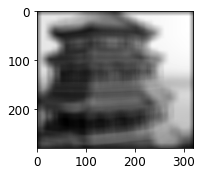

In [ ]:
output = tf.nn.conv2d(china, filters, strides=[1,1,1,1], padding="SAME")
output = output.numpy()
output.shape
plt.imshow(output[0, :, :, 0], cmap='gray')
plt.show()

### <span style="color:#0b486b"> IV.3. Applying other filters to the china image </span>

(1, 280, 320, 5)
----------------------------------------------------------------------------------------------------
Sharpen effect


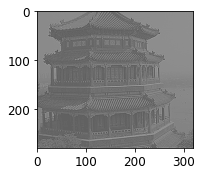

----------------------------------------------------------------------------------------------------
Lalapcian effect


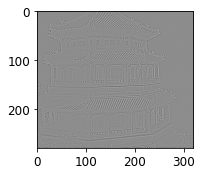

----------------------------------------------------------------------------------------------------
SobelX effect


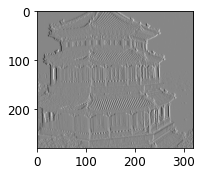

----------------------------------------------------------------------------------------------------
SobelY effect


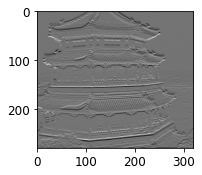

----------------------------------------------------------------------------------------------------
Emboss effect


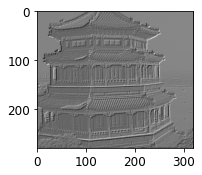

In [ ]:
output = tf.nn.conv2d(china, effect_filters, strides=[1,1,1,1], padding="SAME")
output = output.numpy()
print(output.shape)
print("-"*100)
print("Sharpen effect")
plt.imshow(output[0, :, :, 0], cmap='gray')
plt.show()
print("-"*100)
print("Lalapcian effect")
plt.imshow(output[0, :, :, 1], cmap='gray')
plt.show()
print("-"*100)
print("SobelX effect")
plt.imshow(output[0, :, :, 2], cmap='gray')
plt.show()
print("-"*100)
print("SobelY effect")
plt.imshow(output[0, :, :, 3], cmap='gray')
plt.show()
print("-"*100)
print("Emboss effect")
plt.imshow(output[0, :, :, 4], cmap='gray')
plt.show()

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>